# Ride Along with Lucy!

In [2]:
from spacerocks.spacerock import SpaceRock
from spacerocks.simulation import Simulation
from spacerocks.model import PerturberModel, builtin_models
from spacerocks.units import Units
from spacerocks.spice import SpiceBody, SpiceKernel
from spacerocks.utils import time_handler


import numpy as np
from astropy import units as u
from astropy.time import Time

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%pwd

'/Users/gerdes/PycharmProjects/LucyOcc/Notebooks'

In [5]:
epoch = time_handler('26 June 2022').utc.jd


kernel = SpiceKernel()
kernel.spk += ["../spice/lcy_211016_330403_230131_OD032-R-TCM08a-P-TCM36-P_v1.bsp"]
kernel.furnsh()

lucy_spice = SpiceBody(spiceid="Lucy", kernel=kernel)
lucy_spacerock = lucy_spice.at(epoch) # this is a SpaceRock object.


In [3]:
#polymele = SpaceRock.from_horizons("Polymele")

In [6]:
units = Units()
units.timescale = 'tdb' 
units.mass = u.M_sun

spiceids, kernel, _ = builtin_models['HORIZONS']
model = PerturberModel(spiceids=spiceids, kernel=kernel)
sim = Simulation(model=model,  epoch=epoch, units=units)
sim.dt = 1
sim.integrator = 'ias15'


# Add the other Lucy targets
Lucy_targets = ['Eurybates', 'Polymele','Leucus', 'Orus', 'Patroclus']
for target in Lucy_targets:
    rock = SpaceRock.from_horizons(target)
    sim.add_spacerocks(rock)

In [7]:
t_start = Time('2023-01-01', format='iso', scale='tdb')
t_end = Time('2033-04-01', format='iso', scale='tdb')
epochs = np.arange(t_start.jd, t_end.jd, 5)

In [8]:
prop, planets, _ = sim.propagate(epochs=epochs, units=units, exact_finish_time=1)

Output()

In [9]:
lucy_x, lucy_y, lucy_z = np.zeros(len(epochs)), np.zeros(len(epochs)), np.zeros(len(epochs))
lucy_vx, lucy_vy, lucy_vz = np.zeros(len(epochs)), np.zeros(len(epochs)), np.zeros(len(epochs))
for i, epoch in enumerate(epochs):
    try:
        lucy = lucy_spice.at(epoch)
        lucy_x[i]= lucy.x.au
        lucy_y[i] = lucy.y.au
        lucy_z[i] = lucy.z.au
        lucy_vx[i]= lucy.vx[0].value
        lucy_vy[i] = lucy.vy[0].value
        lucy_vz[i] = lucy.vz[0].value
    except:
        print(f'Spice error at epoch {epoch}')
    

Spice error at epoch 2460250.5
Spice error at epoch 2460785.5
Spice error at epoch 2461630.5
Spice error at epoch 2461665.5
Spice error at epoch 2461880.5
Spice error at epoch 2463660.5


In [12]:
lucy_spacerock = lucy # save the state of Lucy at the final epoch above

In [13]:
jup = planets[planets.name=="Jupiter Barycenter"]

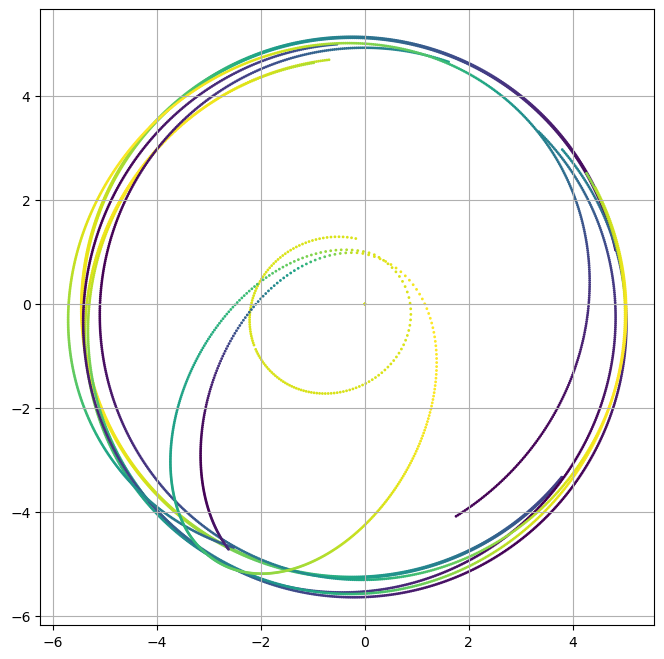

In [14]:
fig, ax = plt.subplots(1, figsize=(12,8))
ax.scatter(jup.x.au, jup.y.au, c=jup.z, s=3)
for target in Lucy_targets:
    ast = prop[prop.name==target]
    ax.scatter(ast.x.au, ast.y.au, c=ast.z, s=1)
ax.scatter(lucy_x, lucy_y, c=lucy_z, s=1)
ax.set_aspect('equal')
ax.grid()

In [15]:
#get x, y positions in Jupiter's co-rotating frame 
jup_angle = jup.true_longitude 
rot = jup_angle - jup_angle[0] # Jupiter rotates through this angle for each step 
x_jup = jup.x.au * np.cos(-rot) - jup.y.au * np.sin(-rot)
y_jup = jup.x.au * np.sin(-rot) + jup.y.au * np.cos(-rot)
x_lucy = lucy_x * np.cos(-rot) - lucy_y * np.sin(-rot)
y_lucy = lucy_x * np.sin(-rot) + lucy_y * np.cos(-rot)

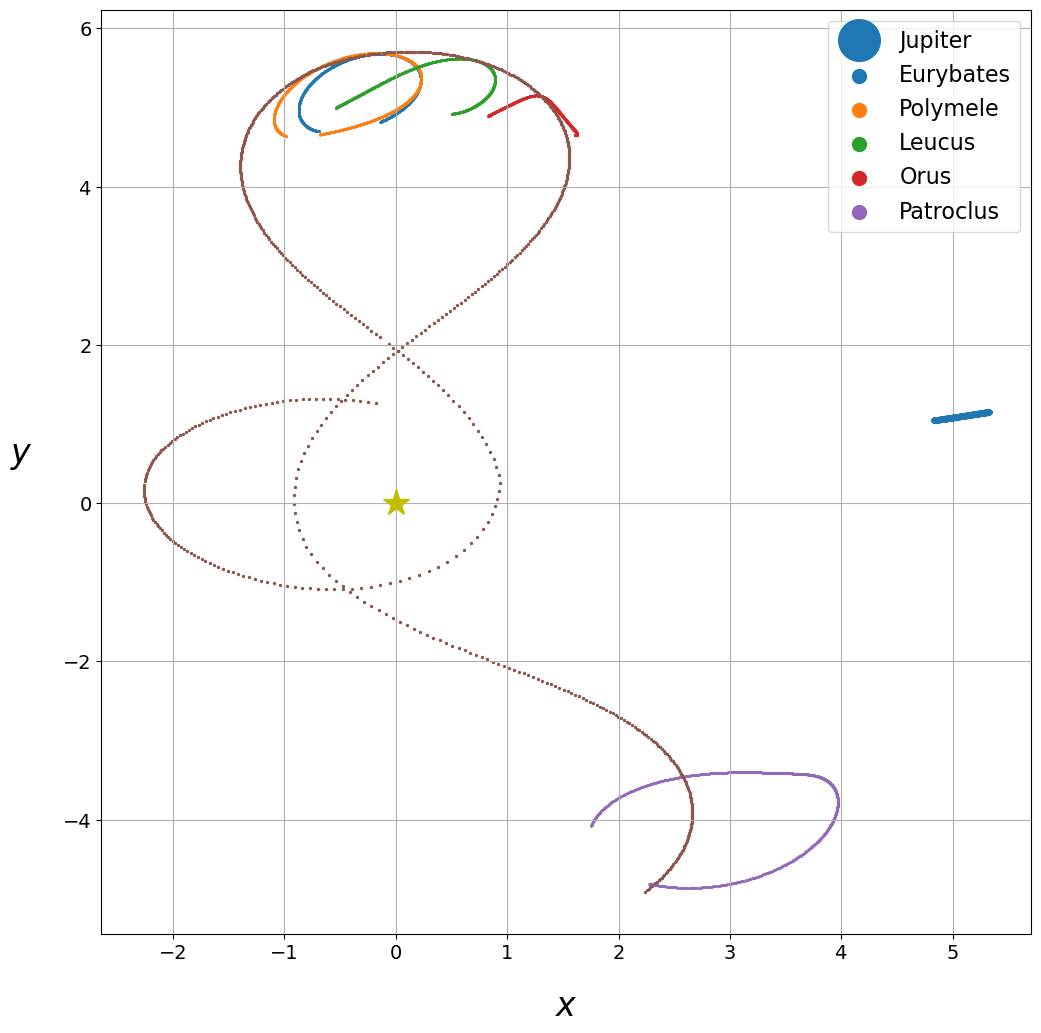

In [16]:
# Plot postions in Jupiter's co-rotating frame
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(0, 0, '*', markersize=20, color='y',)
ax.plot(x_jup, y_jup, '.', label ='Jupiter')
for target in Lucy_targets:
    ast = prop[prop.name==target]
    x_ast = ast.x.au * np.cos(-rot) - ast.y.au * np.sin(-rot)
    y_ast = ast.x.au * np.sin(-rot) + ast.y.au * np.cos(-rot)
    ax.scatter(x_ast, y_ast, s=1, label=ast.name[0])
ax.scatter(x_lucy, y_lucy, s=2)
ax.legend(fontsize=16, markerscale=10)
#ax.legend(fontsize=24)
ax.tick_params(labelsize=14)
ax.set_xlabel(r'$x$', fontsize=24, labelpad=20)
ax.set_ylabel(r'$y$', fontsize=24, labelpad=30, rotation=0)
ax.grid()
plt.savefig('Lucy-corotating.png')

In [17]:
lucy_epoch = Time(epochs[-1], format='jd', scale='tdb')
lucy_epoch.iso

'2033-03-29 00:00:00.000'

In [18]:
# What happens after the last encounter?
t_extended_start = Time('2033-04-01', format='iso', scale='tdb')
t_extended_end = Time('2153-04-01', format='iso', scale='tdb')
extended_epochs = np.arange(t_extended_start.jd, t_extended_end.jd, 5)

In [19]:
units = Units()
units.timescale = 'tdb' 
units.mass = u.M_sun

spiceids, kernel, _ = builtin_models['HORIZONS']
model = PerturberModel(spiceids=spiceids, kernel=kernel)
sim = Simulation(model=model,  epoch=epoch, units=units)
sim.dt = 1
sim.integrator = 'ias15'

sim.add_spacerocks(lucy_spacerock)

# Add the other Lucy targets
Lucy_targets = ['Eurybates', 'Polymele','Leucus', 'Orus', 'Patroclus']
for target in Lucy_targets:
    rock = SpaceRock.from_horizons(target)
    sim.add_spacerocks(rock)

/Users/gerdes/.local/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [20]:
prop, planets, _ = sim.propagate(epochs=extended_epochs, units=units, exact_finish_time=1)

Output()

In [21]:
lucy = prop[prop.name=="Lucy"]

In [22]:
lucy.epoch[-1].iso

'2153-03-28 00:00:00.000'

In [23]:
#get x, y positions in Jupiter's co-rotating frame 
jup = planets[planets.name=="Jupiter Barycenter"]

jup_angle = jup.true_longitude 
rot = jup_angle - jup_angle[0] # Jupiter rotates through this angle for each step 
x_jup = jup.x.au * np.cos(-rot) - jup.y.au * np.sin(-rot)
y_jup = jup.x.au * np.sin(-rot) + jup.y.au * np.cos(-rot)
x_lucy = lucy.x.au * np.cos(-rot) - lucy.y.au * np.sin(-rot)
y_lucy = lucy.x.au * np.sin(-rot) + lucy.y.au * np.cos(-rot)



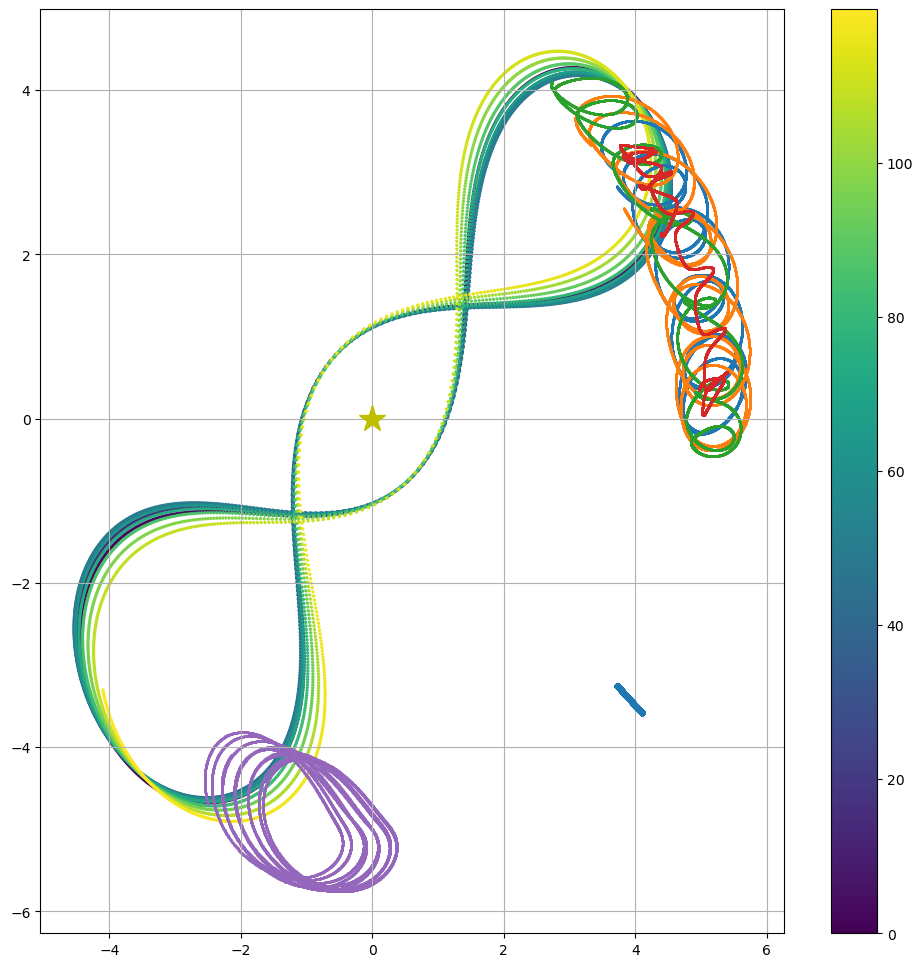

In [24]:
# Plot postions in Jupiter's co-rotating frame
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(0, 0, '*', markersize=20, color='y',)
ax.plot(x_jup, y_jup, '.', label ='Jupiter')
sc = ax.scatter(x_lucy, y_lucy, s=2, c=(lucy.epoch.mjd-lucy.epoch.mjd[0])/365.25)
for target in Lucy_targets:
    ast = prop[prop.name==target]
    x_ast = ast.x.au * np.cos(-rot) - ast.y.au * np.sin(-rot)
    y_ast = ast.x.au * np.sin(-rot) + ast.y.au * np.cos(-rot)
    ax.scatter(x_ast, y_ast, s=1, label=ast.name[0])
ax.grid()
plt.savefig('Lucy_extended.png')
plt.colorbar(sc)

In [25]:
lucy.epoch[-1].iso

'2153-03-28 00:00:00.000'